In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

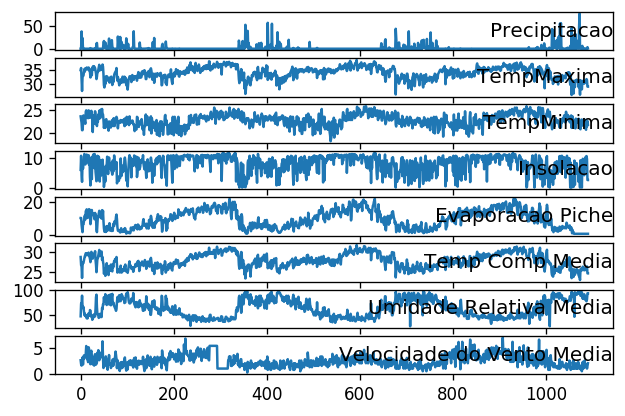

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler * inv_y_hat
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler * inv_y_test
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nMinimum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 0.8399 - mean_squared_error: 0.9319 - val_loss: 0.1034 - val_mean_squared_error: 0.0108
Epoch 2/1000
 - 0s - loss: 0.1441 - mean_squared_error: 0.0365 - val_loss: 0.1032 - val_mean_squared_error: 0.0169
Epoch 3/1000
 - 0s - loss: 0.0792 - mean_squared_error: 0.0105 - val_loss: 0.1475 - val_mean_squared_error: 0.0354
Epoch 4/1000
 - 0s - loss: 0.0637 - mean_squared_error: 0.0066 - val_loss: 0.1082 - val_mean_squared_error: 0.0204
Epoch 5/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0924 - val_mean_squared_error: 0.0155
Epoch 6/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.1013 - val_mean_squared_error: 0.0188
Epoch 7/1000
 - 0s - loss: 0.0586 - mean_squared_error: 0.0056 - val_loss: 0.0925 - val_mean_squared_error: 0.0163
Epoch 8/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0058 - val_loss: 0.1047 - val_mean_squared_error: 0.0180
Epoch 9/1000
 - 0s - loss: 0.0582 -

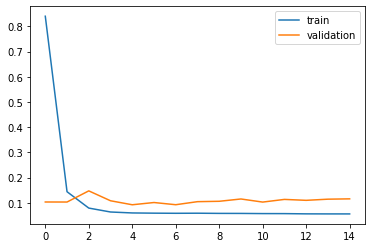


predict: [[31.79031688 22.56145139]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8303 - mean_squared_error: 1.0248 - val_loss: 0.5096 - val_mean_squared_error: 0.4321
Epoch 2/1000
 - 1s - loss: 0.2562 - mean_squared_error: 0.1552 - val_loss: 0.1434 - val_mean_squared_error: 0.0342
Epoch 3/1000
 - 0s - loss: 0.0894 - mean_squared_error: 0.0139 - val_loss: 0.0445 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 0s - loss: 0.0666 - mean_squared_error: 0.0073 - val_loss: 0.0767 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0061 - val_loss: 0.0882 - val_mean_squared_error: 0.0079
Epoch 6/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0062 - val_loss: 0.0534 - val_mean_squared_error: 0.0030
Epoch 7/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0698 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0058 - val_loss: 0.0704 - va

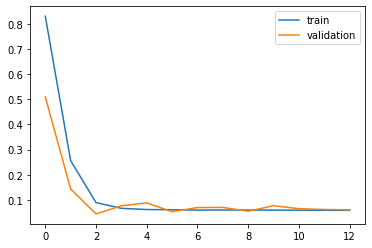


predict: [[30.88560643 23.15687462]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8467 - mean_squared_error: 0.9090 - val_loss: 0.3731 - val_mean_squared_error: 0.2329
Epoch 2/1000
 - 0s - loss: 0.1944 - mean_squared_error: 0.0842 - val_loss: 0.1358 - val_mean_squared_error: 0.0217
Epoch 3/1000
 - 0s - loss: 0.0803 - mean_squared_error: 0.0100 - val_loss: 0.0589 - val_mean_squared_error: 0.0047
Epoch 4/1000
 - 0s - loss: 0.0632 - mean_squared_error: 0.0068 - val_loss: 0.0259 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.0466 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 0s - loss: 0.0615 - mean_squared_error: 0.0060 - val_loss: 0.0532 - val_mean_squared_error: 0.0042
Epoch 7/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0060 - val_loss: 0.0257 - val_mean_squared_error: 9.3121e-04
Epoch 8/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0255 

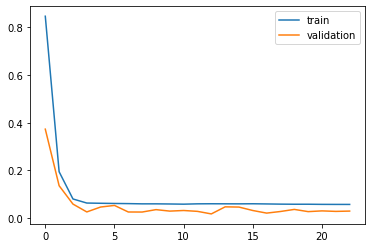


predict: [[32.01496864 23.24838373]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9329 - mean_squared_error: 1.1585 - val_loss: 0.6308 - val_mean_squared_error: 0.4944
Epoch 2/1000
 - 0s - loss: 0.5611 - mean_squared_error: 0.5147 - val_loss: 0.3965 - val_mean_squared_error: 0.2029
Epoch 3/1000
 - 0s - loss: 0.2550 - mean_squared_error: 0.1238 - val_loss: 0.1365 - val_mean_squared_error: 0.0187
Epoch 4/1000
 - 0s - loss: 0.0846 - mean_squared_error: 0.0124 - val_loss: 0.0936 - val_mean_squared_error: 0.0097
Epoch 5/1000
 - 0s - loss: 0.0682 - mean_squared_error: 0.0075 - val_loss: 0.1171 - val_mean_squared_error: 0.0141
Epoch 6/1000
 - 0s - loss: 0.0662 - mean_squared_error: 0.0073 - val_loss: 0.0926 - val_mean_squared_error: 0.0092
Epoch 7/1000
 - 0s - loss: 0.0617 - mean_squared_error: 0.0063 - val_loss: 0.0973 - val_mean_squared_error: 0.0097
Epoch 8/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.1077 - va

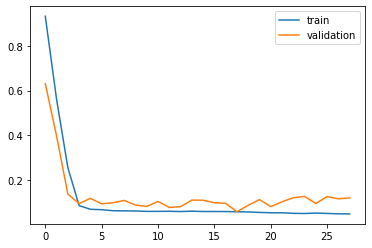


predict: [[31.83398314 21.67968571]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6524 - mean_squared_error: 0.6363 - val_loss: 0.1973 - val_mean_squared_error: 0.0487
Epoch 2/1000
 - 0s - loss: 0.1179 - mean_squared_error: 0.0223 - val_loss: 0.1597 - val_mean_squared_error: 0.0263
Epoch 3/1000
 - 0s - loss: 0.0704 - mean_squared_error: 0.0080 - val_loss: 0.1130 - val_mean_squared_error: 0.0142
Epoch 4/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0064 - val_loss: 0.0915 - val_mean_squared_error: 0.0085
Epoch 5/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.1072 - val_mean_squared_error: 0.0117
Epoch 6/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0842 - val_mean_squared_error: 0.0071
Epoch 7/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0835 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 0s - loss: 0.0585 - mean_squared_error: 0.0056 - val_loss: 0.1191 - va

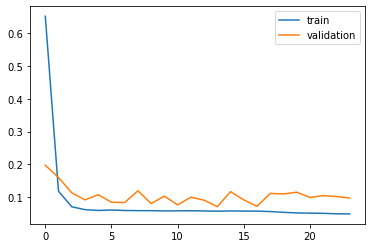


predict: [[32.31829006 21.94955473]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6559 - mean_squared_error: 0.5621 - val_loss: 0.0856 - val_mean_squared_error: 0.0146
Epoch 2/1000
 - 0s - loss: 0.1109 - mean_squared_error: 0.0190 - val_loss: 0.0865 - val_mean_squared_error: 0.0107
Epoch 3/1000
 - 0s - loss: 0.0740 - mean_squared_error: 0.0084 - val_loss: 0.1078 - val_mean_squared_error: 0.0134
Epoch 4/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0063 - val_loss: 0.0875 - val_mean_squared_error: 0.0080
Epoch 5/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0058 - val_loss: 0.0748 - val_mean_squared_error: 0.0066
Epoch 6/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0611 - val_mean_squared_error: 0.0042
Epoch 7/1000
 - 0s - loss: 0.0586 - mean_squared_error: 0.0057 - val_loss: 0.0711 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0057 - val_loss: 0.0817 - va

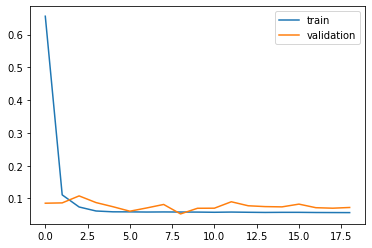


predict: [[31.75587194 22.7439826 ]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9694 - mean_squared_error: 1.2030 - val_loss: 0.5451 - val_mean_squared_error: 0.5324
Epoch 2/1000
 - 0s - loss: 0.4261 - mean_squared_error: 0.3537 - val_loss: 0.0714 - val_mean_squared_error: 0.0061
Epoch 3/1000
 - 0s - loss: 0.0980 - mean_squared_error: 0.0172 - val_loss: 0.1161 - val_mean_squared_error: 0.0208
Epoch 4/1000
 - 0s - loss: 0.0714 - mean_squared_error: 0.0083 - val_loss: 0.0816 - val_mean_squared_error: 0.0108
Epoch 5/1000
 - 0s - loss: 0.0640 - mean_squared_error: 0.0069 - val_loss: 0.0754 - val_mean_squared_error: 0.0092
Epoch 6/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0063 - val_loss: 0.0972 - val_mean_squared_error: 0.0149
Epoch 7/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0061 - val_loss: 0.0681 - val_mean_squared_error: 0.0079
Epoch 8/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0058 - val_loss: 0.0638 - va

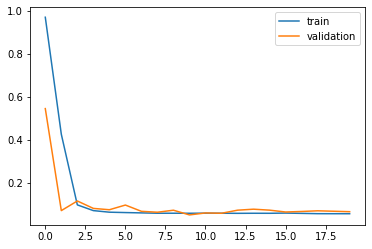


predict: [[32.36631289 22.39982431]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4647 - mean_squared_error: 0.3757 - val_loss: 0.2148 - val_mean_squared_error: 0.0790
Epoch 2/1000
 - 0s - loss: 0.1061 - mean_squared_error: 0.0178 - val_loss: 0.0898 - val_mean_squared_error: 0.0144
Epoch 3/1000
 - 0s - loss: 0.0679 - mean_squared_error: 0.0073 - val_loss: 0.0815 - val_mean_squared_error: 0.0079
Epoch 4/1000
 - 0s - loss: 0.0630 - mean_squared_error: 0.0064 - val_loss: 0.0781 - val_mean_squared_error: 0.0087
Epoch 5/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0062 - val_loss: 0.0706 - val_mean_squared_error: 0.0089
Epoch 6/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0062 - val_loss: 0.0897 - val_mean_squared_error: 0.0127
Epoch 7/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0060 - val_loss: 0.0719 - val_mean_squared_error: 0.0094
Epoch 8/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0725 - va

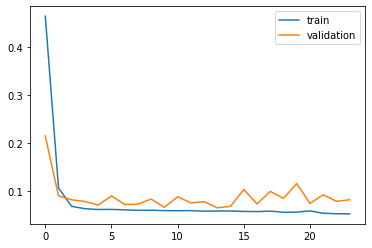


predict: [[31.27215789 22.58234757]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8206 - mean_squared_error: 0.8027 - val_loss: 0.2529 - val_mean_squared_error: 0.0711
Epoch 2/1000
 - 0s - loss: 0.1681 - mean_squared_error: 0.0465 - val_loss: 0.0523 - val_mean_squared_error: 0.0047
Epoch 3/1000
 - 0s - loss: 0.0807 - mean_squared_error: 0.0108 - val_loss: 0.0946 - val_mean_squared_error: 0.0122
Epoch 4/1000
 - 0s - loss: 0.0667 - mean_squared_error: 0.0074 - val_loss: 0.0547 - val_mean_squared_error: 0.0052
Epoch 5/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0064 - val_loss: 0.0554 - val_mean_squared_error: 0.0056
Epoch 6/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0511 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0058 - val_loss: 0.0465 - val_mean_squared_error: 0.0039
Epoch 8/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.0510 - va

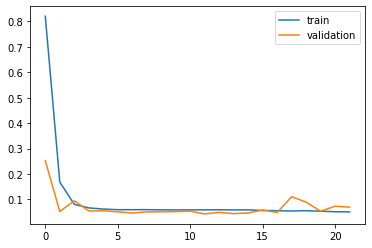


predict: [[32.08355944 22.82110656]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5345 - mean_squared_error: 0.4394 - val_loss: 0.2016 - val_mean_squared_error: 0.0412
Epoch 2/1000
 - 0s - loss: 0.1241 - mean_squared_error: 0.0223 - val_loss: 0.0637 - val_mean_squared_error: 0.0046
Epoch 3/1000
 - 0s - loss: 0.0730 - mean_squared_error: 0.0084 - val_loss: 0.0365 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 0s - loss: 0.0649 - mean_squared_error: 0.0068 - val_loss: 0.0436 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0062 - val_loss: 0.0550 - val_mean_squared_error: 0.0046
Epoch 6/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0061 - val_loss: 0.0387 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0061 - val_loss: 0.0451 - val_mean_squared_error: 0.0026
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0059 - val_loss: 0.0547 - va

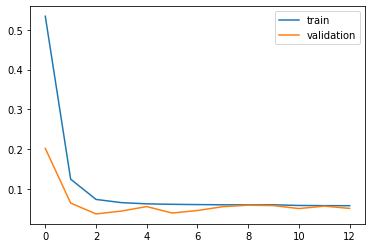


predict: [[31.17149364 21.93936735]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5366 - mean_squared_error: 0.4375 - val_loss: 0.3034 - val_mean_squared_error: 0.0993
Epoch 2/1000
 - 0s - loss: 0.1313 - mean_squared_error: 0.0263 - val_loss: 0.0610 - val_mean_squared_error: 0.0069
Epoch 3/1000
 - 0s - loss: 0.0769 - mean_squared_error: 0.0094 - val_loss: 0.0831 - val_mean_squared_error: 0.0092
Epoch 4/1000
 - 0s - loss: 0.0647 - mean_squared_error: 0.0067 - val_loss: 0.0526 - val_mean_squared_error: 0.0053
Epoch 5/1000
 - 0s - loss: 0.0613 - mean_squared_error: 0.0061 - val_loss: 0.0379 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0060 - val_loss: 0.0328 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 0s - loss: 0.0613 - mean_squared_error: 0.0062 - val_loss: 0.0453 - val_mean_squared_error: 0.0026
Epoch 8/1000
 - 0s - loss: 0.0628 - mean_squared_error: 0.0063 - val_loss: 0.0517 - va

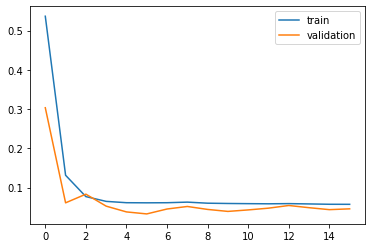


predict: [[31.38971642 22.39221222]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4942 - mean_squared_error: 0.3914 - val_loss: 0.2349 - val_mean_squared_error: 0.1040
Epoch 2/1000
 - 0s - loss: 0.1222 - mean_squared_error: 0.0275 - val_loss: 0.0737 - val_mean_squared_error: 0.0084
Epoch 3/1000
 - 0s - loss: 0.0782 - mean_squared_error: 0.0099 - val_loss: 0.0955 - val_mean_squared_error: 0.0092
Epoch 4/1000
 - 0s - loss: 0.0666 - mean_squared_error: 0.0071 - val_loss: 0.0579 - val_mean_squared_error: 0.0052
Epoch 5/1000
 - 0s - loss: 0.0648 - mean_squared_error: 0.0066 - val_loss: 0.0991 - val_mean_squared_error: 0.0110
Epoch 6/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0063 - val_loss: 0.1193 - val_mean_squared_error: 0.0183
Epoch 7/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.1150 - val_mean_squared_error: 0.0175
Epoch 8/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.1275 - va

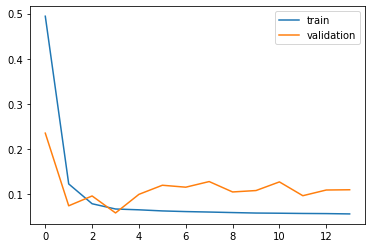


predict: [[30.82184068 20.99670897]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.2168 - mean_squared_error: 1.5618 - val_loss: 0.8821 - val_mean_squared_error: 1.2060
Epoch 2/1000
 - 0s - loss: 0.8857 - mean_squared_error: 1.2579 - val_loss: 0.7571 - val_mean_squared_error: 0.9120
Epoch 3/1000
 - 0s - loss: 0.5901 - mean_squared_error: 0.5969 - val_loss: 0.4608 - val_mean_squared_error: 0.2877
Epoch 4/1000
 - 0s - loss: 0.2360 - mean_squared_error: 0.1040 - val_loss: 0.1731 - val_mean_squared_error: 0.0521
Epoch 5/1000
 - 0s - loss: 0.0802 - mean_squared_error: 0.0103 - val_loss: 0.1361 - val_mean_squared_error: 0.0236
Epoch 6/1000
 - 0s - loss: 0.0639 - mean_squared_error: 0.0067 - val_loss: 0.1310 - val_mean_squared_error: 0.0330
Epoch 7/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.1108 - val_mean_squared_error: 0.0233
Epoch 8/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0059 - val_loss: 0.1296 - va

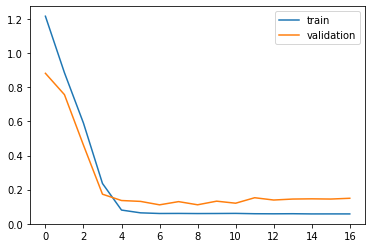


predict: [[31.66494512 22.85025798]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6704 - mean_squared_error: 0.6267 - val_loss: 0.1824 - val_mean_squared_error: 0.0348
Epoch 2/1000
 - 0s - loss: 0.1388 - mean_squared_error: 0.0304 - val_loss: 0.1815 - val_mean_squared_error: 0.0530
Epoch 3/1000
 - 0s - loss: 0.0806 - mean_squared_error: 0.0104 - val_loss: 0.0898 - val_mean_squared_error: 0.0140
Epoch 4/1000
 - 0s - loss: 0.0677 - mean_squared_error: 0.0077 - val_loss: 0.1060 - val_mean_squared_error: 0.0205
Epoch 5/1000
 - 0s - loss: 0.0628 - mean_squared_error: 0.0065 - val_loss: 0.0952 - val_mean_squared_error: 0.0167
Epoch 6/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0060 - val_loss: 0.1015 - val_mean_squared_error: 0.0185
Epoch 7/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0872 - val_mean_squared_error: 0.0147
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0058 - val_loss: 0.0846 - va

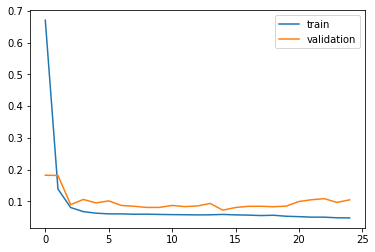


predict: [[31.01459102 22.49664017]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1583 - mean_squared_error: 1.4650 - val_loss: 0.7392 - val_mean_squared_error: 0.5917
Epoch 2/1000
 - 0s - loss: 0.5122 - mean_squared_error: 0.3685 - val_loss: 0.1000 - val_mean_squared_error: 0.0106
Epoch 3/1000
 - 0s - loss: 0.1050 - mean_squared_error: 0.0182 - val_loss: 0.1016 - val_mean_squared_error: 0.0104
Epoch 4/1000
 - 0s - loss: 0.0698 - mean_squared_error: 0.0075 - val_loss: 0.0810 - val_mean_squared_error: 0.0082
Epoch 5/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0063 - val_loss: 0.0580 - val_mean_squared_error: 0.0049
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0732 - val_mean_squared_error: 0.0070
Epoch 7/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0057 - val_loss: 0.0709 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0697 - va

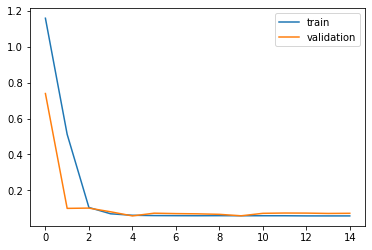


predict: [[32.1135393  22.43779473]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.2008 - mean_squared_error: 2.2281 - val_loss: 0.6812 - val_mean_squared_error: 0.6742
Epoch 2/1000
 - 0s - loss: 0.5026 - mean_squared_error: 0.4496 - val_loss: 0.2842 - val_mean_squared_error: 0.1231
Epoch 3/1000
 - 0s - loss: 0.1918 - mean_squared_error: 0.0739 - val_loss: 0.1250 - val_mean_squared_error: 0.0170
Epoch 4/1000
 - 0s - loss: 0.0765 - mean_squared_error: 0.0102 - val_loss: 0.0997 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 0s - loss: 0.0670 - mean_squared_error: 0.0072 - val_loss: 0.1160 - val_mean_squared_error: 0.0135
Epoch 6/1000
 - 0s - loss: 0.0637 - mean_squared_error: 0.0068 - val_loss: 0.0941 - val_mean_squared_error: 0.0090
Epoch 7/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.0841 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0059 - val_loss: 0.1050 - va

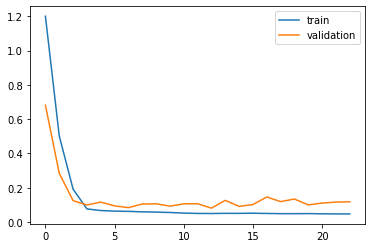


predict: [[30.97409029 21.93077993]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1684 - mean_squared_error: 1.4124 - val_loss: 0.7905 - val_mean_squared_error: 0.6255
Epoch 2/1000
 - 0s - loss: 0.8149 - mean_squared_error: 0.6937 - val_loss: 0.3207 - val_mean_squared_error: 0.1858
Epoch 3/1000
 - 0s - loss: 0.3169 - mean_squared_error: 0.1416 - val_loss: 0.2342 - val_mean_squared_error: 0.0818
Epoch 4/1000
 - 0s - loss: 0.0976 - mean_squared_error: 0.0135 - val_loss: 0.2377 - val_mean_squared_error: 0.0748
Epoch 5/1000
 - 0s - loss: 0.0728 - mean_squared_error: 0.0083 - val_loss: 0.2470 - val_mean_squared_error: 0.0819
Epoch 6/1000
 - 0s - loss: 0.0665 - mean_squared_error: 0.0071 - val_loss: 0.2280 - val_mean_squared_error: 0.0778
Epoch 7/1000
 - 0s - loss: 0.0633 - mean_squared_error: 0.0066 - val_loss: 0.2279 - val_mean_squared_error: 0.0723
Epoch 8/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.2256 - va

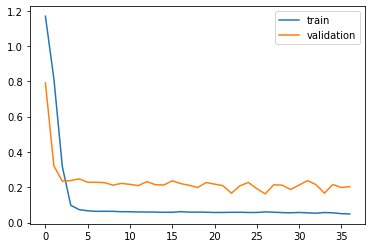


predict: [[30.89290885 22.32518565]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6520 - mean_squared_error: 0.6010 - val_loss: 0.2036 - val_mean_squared_error: 0.0611
Epoch 2/1000
 - 0s - loss: 0.1468 - mean_squared_error: 0.0324 - val_loss: 0.1321 - val_mean_squared_error: 0.0236
Epoch 3/1000
 - 0s - loss: 0.0757 - mean_squared_error: 0.0092 - val_loss: 0.1172 - val_mean_squared_error: 0.0144
Epoch 4/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0064 - val_loss: 0.1425 - val_mean_squared_error: 0.0245
Epoch 5/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0061 - val_loss: 0.1253 - val_mean_squared_error: 0.0174
Epoch 6/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0062 - val_loss: 0.1256 - val_mean_squared_error: 0.0188
Epoch 7/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0060 - val_loss: 0.1102 - val_mean_squared_error: 0.0137
Epoch 8/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.1257 - va

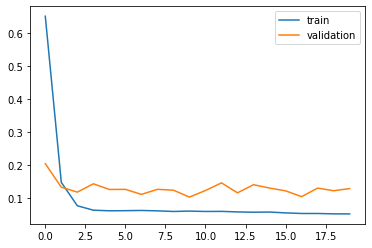


predict: [[31.12841232 19.97397549]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4103 - mean_squared_error: 0.2862 - val_loss: 0.1965 - val_mean_squared_error: 0.0679
Epoch 2/1000
 - 0s - loss: 0.1049 - mean_squared_error: 0.0185 - val_loss: 0.0858 - val_mean_squared_error: 0.0074
Epoch 3/1000
 - 0s - loss: 0.0709 - mean_squared_error: 0.0082 - val_loss: 0.0656 - val_mean_squared_error: 0.0046
Epoch 4/1000
 - 0s - loss: 0.0678 - mean_squared_error: 0.0075 - val_loss: 0.0944 - val_mean_squared_error: 0.0093
Epoch 5/1000
 - 0s - loss: 0.0647 - mean_squared_error: 0.0069 - val_loss: 0.0558 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 0s - loss: 0.0633 - mean_squared_error: 0.0066 - val_loss: 0.0563 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 0s - loss: 0.0632 - mean_squared_error: 0.0065 - val_loss: 0.0523 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.0625 - va

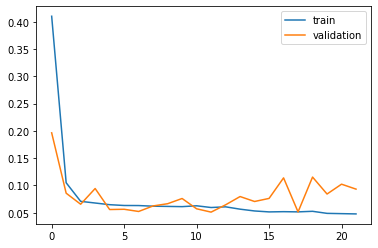


predict: [[30.81701563 21.38827868]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6407 - mean_squared_error: 0.5628 - val_loss: 0.2918 - val_mean_squared_error: 0.1120
Epoch 2/1000
 - 0s - loss: 0.1376 - mean_squared_error: 0.0304 - val_loss: 0.0856 - val_mean_squared_error: 0.0119
Epoch 3/1000
 - 0s - loss: 0.0757 - mean_squared_error: 0.0097 - val_loss: 0.0888 - val_mean_squared_error: 0.0140
Epoch 4/1000
 - 0s - loss: 0.0650 - mean_squared_error: 0.0067 - val_loss: 0.1206 - val_mean_squared_error: 0.0216
Epoch 5/1000
 - 0s - loss: 0.0624 - mean_squared_error: 0.0062 - val_loss: 0.1351 - val_mean_squared_error: 0.0256
Epoch 6/1000
 - 0s - loss: 0.0643 - mean_squared_error: 0.0067 - val_loss: 0.1402 - val_mean_squared_error: 0.0267
Epoch 7/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0062 - val_loss: 0.1152 - val_mean_squared_error: 0.0200
Epoch 8/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.1293 - va

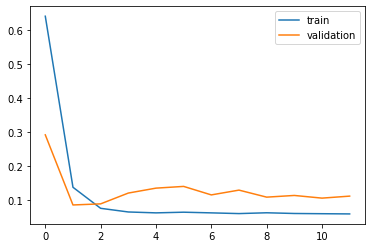


predict: [[32.24564971 22.51059124]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6432 - mean_squared_error: 0.5274 - val_loss: 0.1949 - val_mean_squared_error: 0.0695
Epoch 2/1000
 - 0s - loss: 0.1186 - mean_squared_error: 0.0217 - val_loss: 0.0816 - val_mean_squared_error: 0.0105
Epoch 3/1000
 - 0s - loss: 0.0717 - mean_squared_error: 0.0083 - val_loss: 0.0757 - val_mean_squared_error: 0.0057
Epoch 4/1000
 - 0s - loss: 0.0645 - mean_squared_error: 0.0067 - val_loss: 0.0572 - val_mean_squared_error: 0.0044
Epoch 5/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0474 - val_mean_squared_error: 0.0039
Epoch 6/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.0683 - val_mean_squared_error: 0.0052
Epoch 7/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0063 - val_loss: 0.0786 - val_mean_squared_error: 0.0082
Epoch 8/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0063 - val_loss: 0.0340 - va

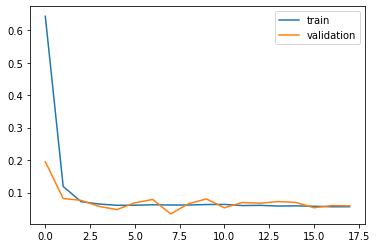


predict: [[31.81625249 22.38993601]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0783 - mean_squared_error: 1.2156 - val_loss: 0.5826 - val_mean_squared_error: 0.3420
Epoch 2/1000
 - 0s - loss: 0.3009 - mean_squared_error: 0.1379 - val_loss: 0.2466 - val_mean_squared_error: 0.0653
Epoch 3/1000
 - 0s - loss: 0.1008 - mean_squared_error: 0.0152 - val_loss: 0.0346 - val_mean_squared_error: 0.0016
Epoch 4/1000
 - 0s - loss: 0.0704 - mean_squared_error: 0.0084 - val_loss: 0.0770 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 0s - loss: 0.0626 - mean_squared_error: 0.0062 - val_loss: 0.0855 - val_mean_squared_error: 0.0087
Epoch 6/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0056 - val_loss: 0.0751 - val_mean_squared_error: 0.0080
Epoch 7/1000
 - 0s - loss: 0.0573 - mean_squared_error: 0.0053 - val_loss: 0.0785 - val_mean_squared_error: 0.0099
Epoch 8/1000
 - 0s - loss: 0.0582 - mean_squared_error: 0.0055 - val_loss: 0.0733 - va

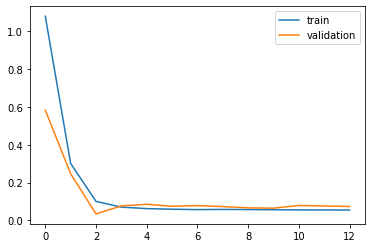


predict: [[32.62109007 22.77606134]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0494 - mean_squared_error: 1.3261 - val_loss: 0.6425 - val_mean_squared_error: 0.6757
Epoch 2/1000
 - 0s - loss: 0.4717 - mean_squared_error: 0.4163 - val_loss: 0.1479 - val_mean_squared_error: 0.0337
Epoch 3/1000
 - 0s - loss: 0.1086 - mean_squared_error: 0.0223 - val_loss: 0.1305 - val_mean_squared_error: 0.0253
Epoch 4/1000
 - 0s - loss: 0.0709 - mean_squared_error: 0.0084 - val_loss: 0.0490 - val_mean_squared_error: 0.0035
Epoch 5/1000
 - 0s - loss: 0.0644 - mean_squared_error: 0.0070 - val_loss: 0.0650 - val_mean_squared_error: 0.0069
Epoch 6/1000
 - 0s - loss: 0.0610 - mean_squared_error: 0.0060 - val_loss: 0.0604 - val_mean_squared_error: 0.0068
Epoch 7/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0465 - val_mean_squared_error: 0.0042
Epoch 8/1000
 - 0s - loss: 0.0583 - mean_squared_error: 0.0056 - val_loss: 0.0627 - va

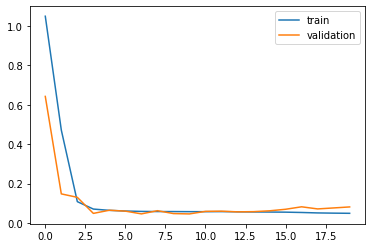


predict: [[32.21157267 22.57477254]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0005 - mean_squared_error: 1.0306 - val_loss: 0.6547 - val_mean_squared_error: 0.4388
Epoch 2/1000
 - 0s - loss: 0.3866 - mean_squared_error: 0.2110 - val_loss: 0.0917 - val_mean_squared_error: 0.0087
Epoch 3/1000
 - 0s - loss: 0.0952 - mean_squared_error: 0.0140 - val_loss: 0.0199 - val_mean_squared_error: 4.4893e-04
Epoch 4/1000
 - 0s - loss: 0.0667 - mean_squared_error: 0.0073 - val_loss: 0.0500 - val_mean_squared_error: 0.0025
Epoch 5/1000
 - 0s - loss: 0.0625 - mean_squared_error: 0.0064 - val_loss: 0.0182 - val_mean_squared_error: 6.0835e-04
Epoch 6/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0306 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0057 - val_loss: 0.0355 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0058 - val_loss: 0.0

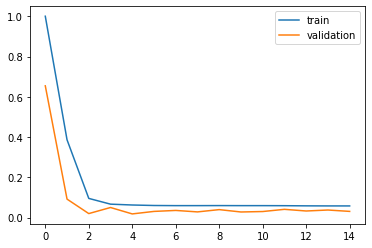


predict: [[31.82342257 23.0618268 ]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9405 - mean_squared_error: 1.1244 - val_loss: 0.5810 - val_mean_squared_error: 0.4438
Epoch 2/1000
 - 0s - loss: 0.5044 - mean_squared_error: 0.4158 - val_loss: 0.2633 - val_mean_squared_error: 0.1361
Epoch 3/1000
 - 0s - loss: 0.2419 - mean_squared_error: 0.1155 - val_loss: 0.0654 - val_mean_squared_error: 0.0063
Epoch 4/1000
 - 0s - loss: 0.0840 - mean_squared_error: 0.0128 - val_loss: 0.0873 - val_mean_squared_error: 0.0125
Epoch 5/1000
 - 0s - loss: 0.0707 - mean_squared_error: 0.0080 - val_loss: 0.0835 - val_mean_squared_error: 0.0108
Epoch 6/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0067 - val_loss: 0.0861 - val_mean_squared_error: 0.0127
Epoch 7/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0063 - val_loss: 0.0753 - val_mean_squared_error: 0.0099
Epoch 8/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0061 - val_loss: 0.0682 - va

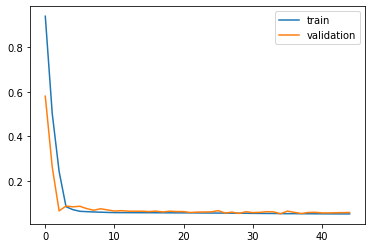


predict: [[32.21804929 21.98158715]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7966 - mean_squared_error: 1.2068 - val_loss: 0.5689 - val_mean_squared_error: 0.6221
Epoch 2/1000
 - 0s - loss: 0.6053 - mean_squared_error: 0.6689 - val_loss: 0.4701 - val_mean_squared_error: 0.4310
Epoch 3/1000
 - 0s - loss: 0.5157 - mean_squared_error: 0.4703 - val_loss: 0.3698 - val_mean_squared_error: 0.2659
Epoch 4/1000
 - 0s - loss: 0.2626 - mean_squared_error: 0.1476 - val_loss: 0.1085 - val_mean_squared_error: 0.0194
Epoch 5/1000
 - 0s - loss: 0.0892 - mean_squared_error: 0.0137 - val_loss: 0.0193 - val_mean_squared_error: 4.6793e-04
Epoch 6/1000
 - 0s - loss: 0.0699 - mean_squared_error: 0.0080 - val_loss: 0.0899 - val_mean_squared_error: 0.0156
Epoch 7/1000
 - 0s - loss: 0.0632 - mean_squared_error: 0.0066 - val_loss: 0.0513 - val_mean_squared_error: 0.0052
Epoch 8/1000
 - 0s - loss: 0.0587 - mean_squared_error: 0.0056 - val_loss: 0.0463 

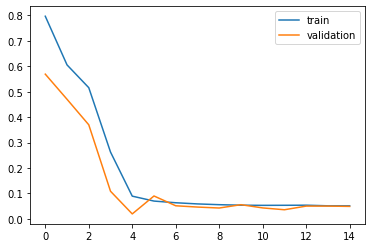


predict: [[31.30170898 22.87341714]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0615 - mean_squared_error: 1.6532 - val_loss: 0.8267 - val_mean_squared_error: 1.0404
Epoch 2/1000
 - 0s - loss: 0.7455 - mean_squared_error: 1.0138 - val_loss: 0.6446 - val_mean_squared_error: 0.6546
Epoch 3/1000
 - 0s - loss: 0.5762 - mean_squared_error: 0.6129 - val_loss: 0.4458 - val_mean_squared_error: 0.2782
Epoch 4/1000
 - 0s - loss: 0.4470 - mean_squared_error: 0.3365 - val_loss: 0.3406 - val_mean_squared_error: 0.1855
Epoch 5/1000
 - 0s - loss: 0.3300 - mean_squared_error: 0.1909 - val_loss: 0.1883 - val_mean_squared_error: 0.0430
Epoch 6/1000
 - 0s - loss: 0.1313 - mean_squared_error: 0.0340 - val_loss: 0.1610 - val_mean_squared_error: 0.0351
Epoch 7/1000
 - 0s - loss: 0.0798 - mean_squared_error: 0.0111 - val_loss: 0.0975 - val_mean_squared_error: 0.0096
Epoch 8/1000
 - 0s - loss: 0.0695 - mean_squared_error: 0.0078 - val_loss: 0.1034 - va

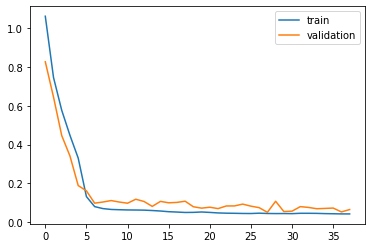


predict: [[31.90666054 22.94888158]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6076 - mean_squared_error: 0.5414 - val_loss: 0.3203 - val_mean_squared_error: 0.1947
Epoch 2/1000
 - 0s - loss: 0.3914 - mean_squared_error: 0.2436 - val_loss: 0.1838 - val_mean_squared_error: 0.0341
Epoch 3/1000
 - 0s - loss: 0.2248 - mean_squared_error: 0.0645 - val_loss: 0.1445 - val_mean_squared_error: 0.0215
Epoch 4/1000
 - 0s - loss: 0.1052 - mean_squared_error: 0.0169 - val_loss: 0.0956 - val_mean_squared_error: 0.0138
Epoch 5/1000
 - 0s - loss: 0.0678 - mean_squared_error: 0.0073 - val_loss: 0.1425 - val_mean_squared_error: 0.0319
Epoch 6/1000
 - 0s - loss: 0.0657 - mean_squared_error: 0.0069 - val_loss: 0.1314 - val_mean_squared_error: 0.0318
Epoch 7/1000
 - 0s - loss: 0.0631 - mean_squared_error: 0.0066 - val_loss: 0.1064 - val_mean_squared_error: 0.0164
Epoch 8/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0060 - val_loss: 0.1156 - va

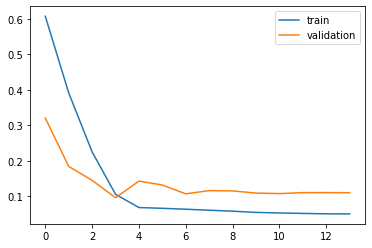


predict: [[32.12317351 22.09878968]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0755 - mean_squared_error: 1.2042 - val_loss: 0.6752 - val_mean_squared_error: 0.5456
Epoch 2/1000
 - 0s - loss: 0.4983 - mean_squared_error: 0.3520 - val_loss: 0.3190 - val_mean_squared_error: 0.1216
Epoch 3/1000
 - 0s - loss: 0.1438 - mean_squared_error: 0.0357 - val_loss: 0.1468 - val_mean_squared_error: 0.0224
Epoch 4/1000
 - 0s - loss: 0.0760 - mean_squared_error: 0.0088 - val_loss: 0.0936 - val_mean_squared_error: 0.0110
Epoch 5/1000
 - 0s - loss: 0.0637 - mean_squared_error: 0.0066 - val_loss: 0.0767 - val_mean_squared_error: 0.0112
Epoch 6/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0061 - val_loss: 0.0567 - val_mean_squared_error: 0.0059
Epoch 7/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0533 - val_mean_squared_error: 0.0053
Epoch 8/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0619 - va

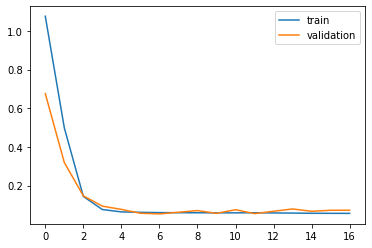


predict: [[32.40190123 22.41851044]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8555 - mean_squared_error: 0.9918 - val_loss: 0.4137 - val_mean_squared_error: 0.1719
Epoch 2/1000
 - 0s - loss: 0.3430 - mean_squared_error: 0.1345 - val_loss: 0.1095 - val_mean_squared_error: 0.0217
Epoch 3/1000
 - 0s - loss: 0.0960 - mean_squared_error: 0.0141 - val_loss: 0.0770 - val_mean_squared_error: 0.0111
Epoch 4/1000
 - 0s - loss: 0.0659 - mean_squared_error: 0.0070 - val_loss: 0.0469 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0058 - val_loss: 0.0739 - val_mean_squared_error: 0.0064
Epoch 6/1000
 - 0s - loss: 0.0573 - mean_squared_error: 0.0055 - val_loss: 0.0731 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 0s - loss: 0.0542 - mean_squared_error: 0.0050 - val_loss: 0.0710 - val_mean_squared_error: 0.0054
Epoch 8/1000
 - 0s - loss: 0.0530 - mean_squared_error: 0.0049 - val_loss: 0.0380 - va

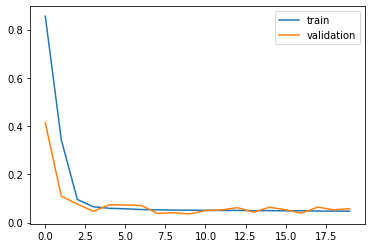


predict: [[30.69347543 21.88366494]]
real:      [[30.1 22.9]]

Maximum temperature
Test RMSE -------------------------- 1.856
Test VARIANCE ---------------------- 0.04814
Test MAX-ERROR --------------------- 5.228
Test MEAN-ABSOLUTE-ERROR ----------- 1.418
Test MEDIAN-ABSOLUTE-ERROR --------- 1.084

Minimum temperature
Test RMSE -------------------------- 0.9072
Test VARIANCE ---------------------- -0.3649
Test MAX-ERROR --------------------- 1.803
Test MEAN-ABSOLUTE-ERROR ----------- 0.7537
Test MEDIAN-ABSOLUTE-ERROR --------- 0.6806


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

mean_scaler = np.mean(values) + 1
dataset_scaled = dataset.div(mean_scaler)

NCV(dataset_scaled, days_to_predict, mean_scaler)